# GLOBAL VARIANCE

### Loading all the required libraries. 



In [ ]:
!pip3 install pysptk

     |████████████████████████████████| 410 kB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pysptk: filename=pysptk-0.1.20-cp37-cp37m-linux_x86_64.whl size=929941 sha256=2f910d51b369a466f0056feaa1f884cab3ae0132ffd7c745fe1e3a83dd2cb092
  Stored in directory: /root/.cache/pip/wheels/dd/37/3f/7583b00bf73e73650aad5d268ee46b95dbd6dffbd237e1bf58
Successfully built pysptk


In [ ]:
!pip3 install pyworld

     |████████████████████████████████| 212 kB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pyworld: filename=pyworld-0.3.0-cp37-cp37m-linux_x86_64.whl size=609504 sha256=97a466ab771ec1030bfaa1e3d16440a9cbd6ba72ebb37499d6069de8f2e916df
  Stored in directory: /root/.cache/pip/wheels/e7/7c/11/c775fffa0e1e7b05a6604b4323408a77f80fb4ab304d96b5c6
Successfully built pyworld


In [ ]:
import torch
from scipy.io import wavfile
import pysptk
from pysptk.synthesis import Synthesizer, MLSADF
import pyworld
from os.path import join, basename
import librosa
import librosa.display
import IPython
from IPython.display import Audio
import glob
import os
import numpy as np
from os.path import join, basename
import collections

# Loading Data 
* Upload your data in your google drive 
* Run the cell below , and your drive will be accessible from this notebook. This will ask for your permission.
* After granting the permission , you can access any folder or file in your drive from this notebook environment.




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def getpaths():  
  """
  This function takes input from the user , i.e. , the number of datasets and the path of the datasets
  
  """
  print("Enter No. of Datasets :")
  n=int(input())
  paths=[]
  for i in range(n):
    if i ==0:
      paths.append(input("Enter Original path : "))
    else:
      paths.append(input(f"Enter path{i} : "))
  return paths

### Enter the number of datasets and the paths :
* Enter a numrical value , like 2/4 with respect to the number of datasets you want to visualize.
* Enter the path of the original data first.
* Then you can put the path of the other datasets. 

### Note : The datasets should contain same number of wav files with the same name of each wav file.

In [ ]:
paths=getpaths()

Enter No. of Datasets :
2
Enter Original path : /content/drive/MyDrive/Male-to-Male-Voice/SM1
Enter path1 : /content/drive/MyDrive/Male-to-Male-Voice/converted_SM2_Speech_in_SM1_Voice


In [ ]:
%pylab inline
from matplotlib import pyplot as plt
rcParams["figure.figsize"] = (16,5)

Populating the interactive namespace from numpy and matplotlib


### Funtion to compute the static feature - 
* Takes wav file path as input.
* Returns the Global variance as output.

In [ ]:
def compute_static_features(wav):
    fs,x=wavfile.read(wav)
    x = x.astype(np.float64)
    f0, timeaxis = pyworld.dio(x, fs, frame_period=5.0)
    f0 = pyworld.stonemask(x, f0, timeaxis, fs)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
    aperiodicity = pyworld.d4c(x, f0, timeaxis, fs)
    alpha = pysptk.util.mcepalpha(fs)
    mc = pysptk.sp2mc(spectrogram, order=24, alpha=alpha) 
    c0, mc = mc[:, 0], mc[:, 1:]
    #print(shape(mc))
    gv=np.var(mc,axis=0)
    #print(gv)
    return gv  #    [x1,x2, ......x24]

### Function to calculate RMSE value 

In [ ]:
def calc_rmse(x,y):
    min=np.sqrt(((x - y) ** 2).mean())
    return min

### Function to visualize GV:
* Takes the paths as input.
* Takes user input for Labels and markers for the plot, with respect to each dataset.
* Calculates the GV of all the datasets.
* Compare the values and shows the best plot from the dataset.

In [ ]:
def vis_gv(paths):
    print("Enter the Labels and Markers for each label [few common markers - x , + , o , * , > , < , D , H , X , v , ^ ]:")
    labels=[]
    marker=[]
    n=len(paths)
    for i in range(n):
      if i ==0:
        labels.append(input("Enter label for Original path : "))
        marker.append(input("Enter marker for Original path : "))
      else:
        labels.append(input(f"Enter label for path_{i} : "))
        marker.append(input(f"ENter marker for path_{i} : "))


    gv_dict = collections.defaultdict(list)
    file_paths={}
    for i in range(n):
      path=glob.glob(paths[i]+'/*')
      file_paths[f'path_{i+1}'] =sorted(path)
      for wav in file_paths[f'path_{i+1}']:
        gv_dict[f'path_{i+1}'].append(compute_static_features(wav))


    mini=[]

    for i in range(len(gv_dict['path_1'])):
      j=1
      min_dif=0
      while (j+1)<=n:
    
        min_dif+=(calc_rmse(gv_dict['path_1'][i],gv_dict[f'path_{j+1}'][i]))
        #print(min_dif,j)
        j+=1
      #print(min_dif)
      mini.append(min_dif)

    #print(len(mini))
    ind=mini.index(min(mini))
    #print(ind)

    figure(figsize=(16,6))
    j=0
    for i in gv_dict.keys():
      plt.plot(gv_dict[i][ind], marker=marker[j] ,linewidth=2, label=labels[j])
      legend(prop={"size": 18})
      yscale("log")
      #xlim(0,24)
      ylabel("GV", fontsize=16)
      xlabel("Index of Mel-cepstral coefficient", fontsize=16)
      plt.savefig('GV.png')
      j+=1

Enter the Labels and Markers for each label [few common markers - x , + , o , * , > , < , D , H , X , v , ^ ]:
Enter label for Original path : Original Audio
Enter marker for Original path : X
Enter label for path_1 : Synthesized Audio
ENter marker for path_1 : *


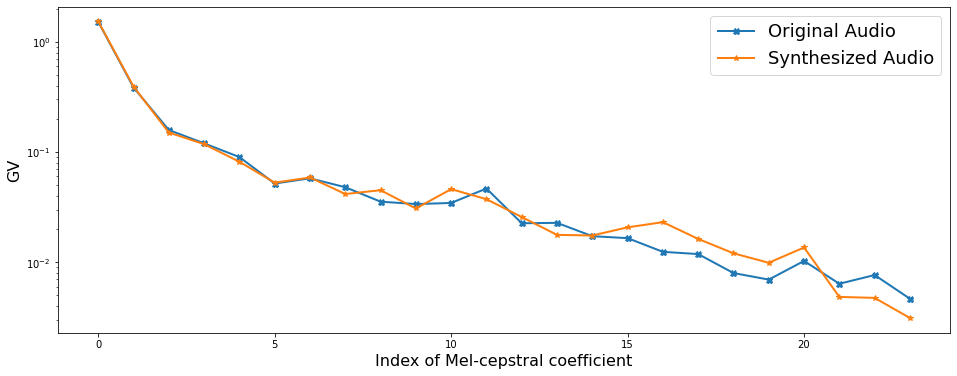

In [ ]:
vis_gv(paths)